In [1]:
!pip install python-levenshtein

     |████████████████████████████████| 50 kB 5.2 MB/s 
  Created wheel for python-levenshtein: filename=python_Levenshtein-0.12.2-cp37-cp37m-linux_x86_64.whl size=149870 sha256=7de669bffbadfb95a55e86a8331865a254f760828b25e9918ce1b1c5bcc218f7
  Stored in directory: /root/.cache/pip/wheels/05/5f/ca/7c4367734892581bb5ff896f15027a932c551080b2abd3e00d
Successfully built python-levenshtein


# Libraries and Initial Processing

In [2]:
import os
import sys
import pandas as pd
import numpy as np
import Levenshtein as lev
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.utils.rnn as rnn_utils
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.nn.utils as utils
import seaborn as sns
import matplotlib.pyplot as plt
import time
import random
import datetime
from torch.utils import data
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
import math
import torchaudio 
import torchaudio.transforms as T

from tqdm import tqdm

cuda = torch.cuda.is_available()

print(cuda, sys.version)

device = torch.device("cuda" if cuda else "cpu")
num_workers = 4 if cuda else 0
print("Cuda = "+str(cuda)+" with num_workers = "+str(num_workers))
np.random.seed(11785)
torch.manual_seed(11785)

# The labels of the dataset contain letters in LETTER_LIST.
# You should use this to convert the letters to the corresponding indices
# and train your model with numerical labels.
LETTER_LIST = ['<sos>', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', \
         'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', "'", ' ', '<eos>', '<pad>']

True 3.7.13 (default, Apr 24 2022, 01:04:09) 
[GCC 7.5.0]
Cuda = True with num_workers = 4


In [3]:
def create_dictionaries(letter_list):
    '''
    Create dictionaries for letter2index and index2letter transformations
    based on LETTER_LIST

    Args:
        letter_list: LETTER_LIST

    Return:
        letter2index: Dictionary mapping from letters to indices
        index2letter: Dictionary mapping from indices to letters
    '''
    letter2index = dict()
    index2letter = dict()
    for i, letter in enumerate(LETTER_LIST):
      letter2index[letter] = i
      index2letter[i] = letter

    return letter2index, index2letter
    

def transform_index_to_letter(batch_indices, letter2index, index2letter):
    transcripts_list = []
    for batch in batch_indices:
        strings = []
        for i in batch:
            if i == letter2index["<eos>"] or i == letter2index["<pad>"]:
                break
            else:
                strings.append(index2letter[i])
        transcripts_list.append("".join(strings))
    return transcripts_list

def transform_index_to_letter_test(batch_indices, letter2index, index2letter):
    transcripts_list = []
    for batch in batch_indices:
        strings = []
        for i in batch:
            if i == letter2index["<eos>"] or i == letter2index["<pad>"]:
                break
            if i == letter2index["<sos>"]:
              continue
            else:
                strings.append(index2letter[i])
        transcripts_list.append("".join(strings))
    return transcripts_list
        
# Create the letter2index and index2letter dictionary
letter2index, index2letter = create_dictionaries(LETTER_LIST)

# Kaggle (TODO)

In [4]:
import json

TOKEN = {"username":"meiirbekislamov","key":"af197071383b4332b004369ebae2a753"}

! pip install kaggle==1.5.12
! mkdir -p .kaggle
! mkdir -p /content & mkdir -p /content/.kaggle & mkdir -p /root/.kaggle/

with open('/content/.kaggle/kaggle.json', 'w') as file:
    json.dump(TOKEN, file)

! pip install --upgrade --force-reinstall --no-deps kaggle
! ls "/content/.kaggle"
! chmod 600 /content/.kaggle/kaggle.json
! cp /content/.kaggle/kaggle.json /root/.kaggle/

! kaggle config set -n path -v /content

     |████████████████████████████████| 58 kB 4.7 MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.12-py3-none-any.whl size=73051 sha256=37d9d7e53887887d4a08f03c19c296a3ff7dbd1acc7325c39e283ade76f15dbb
  Stored in directory: /root/.cache/pip/wheels/62/d6/58/5853130f941e75b2177d281eb7e44b4a98ed46dd155f556dc5
Successfully built kaggle
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.5.12
    Uninstalling kaggle-1.5.12:
      Successfully uninstalled kaggle-1.5.12
kaggle.json
- path is now set to: /content


In [5]:
! kaggle competitions download -c 11-785-s22-hw4p2

 99% 1.82G/1.84G [00:06<00:00, 304MB/s]
100% 1.84G/1.84G [00:06<00:00, 287MB/s]


In [6]:
! unzip /content/competitions/11-785-s22-hw4p2/11-785-s22-hw4p2.zip

Streaming output truncated to the last 5000 lines.
  inflating: hw4p2_student_data/hw4p2_student_data/train/transcript/7113-086041-019.npy  
  inflating: hw4p2_student_data/hw4p2_student_data/train/transcript/7113-086041-020.npy  
  inflating: hw4p2_student_data/hw4p2_student_data/train/transcript/7113-086041-021.npy  
  inflating: hw4p2_student_data/hw4p2_student_data/train/transcript/7113-086041-022.npy  
  inflating: hw4p2_student_data/hw4p2_student_data/train/transcript/7113-086041-023.npy  
  inflating: hw4p2_student_data/hw4p2_student_data/train/transcript/7113-086041-024.npy  
  inflating: hw4p2_student_data/hw4p2_student_data/train/transcript/7113-086041-025.npy  
  inflating: hw4p2_student_data/hw4p2_student_data/train/transcript/7113-086041-026.npy  
  inflating: hw4p2_student_data/hw4p2_student_data/train/transcript/7113-086041-027.npy  
  inflating: hw4p2_student_data/hw4p2_student_data/train/transcript/7113-086041-028.npy  
  inflating: hw4p2_student_data/hw4p2_student_dat

# Dataset and Dataloading (TODO)

You will need to implement the Dataset class by your own. You can implement it similar to HW3P2. However, you are welcomed to do it your own way if it is more comfortable or efficient.

Note that you need to use LETTER_LIST to convert the transcript into numerical labels for the model.


Example of raw transcript:

    ['<sos>', 'N', 'O', 'R', 'T', 'H', 'A', 'N', 'G', 'E', 'R', ' ','A', 'B', 'B', 'E', 'Y', '<eos>']

Example of converted transcript ready to process for the model:

    [0, 14, 15, 18, 20, 8, 1, 14, 7, 5, 18, 28, 1, 2, 2, 5, 25, 29]


In [7]:
class LibriSamples(torch.utils.data.Dataset):

    def __init__(self, data_path, batch_size, partition= "train", mask=True):

      self.batch_size = batch_size

      self.X_dir = data_path + "/" + partition + "/mfcc/"
      self.Y_dir = data_path + "/" + partition +"/transcript/"

      self.X_files = os.listdir(self.X_dir)
      self.Y_files = os.listdir(self.Y_dir)
      self.mask = mask

      self.LETTER_LIST = ['<sos>', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', \
         'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', "'", ' ', '<eos>', '<pad>']

      assert(len(self.X_files) == len(self.Y_files))

    def __len__(self):
      return len(self.X_files)

    def __getitem__(self, ind):

      X_path = self.X_dir + self.X_files[ind]
      Y_path = self.Y_dir + self.Y_files[ind]
      label = [self.LETTER_LIST.index(yy) for yy in np.load(Y_path)]

      X = np.load(X_path)
      X = (X - X.mean(axis=0))/X.std(axis=0)
      X = torch.tensor(X)

      if self.mask:
        maskingFreq = T.FrequencyMasking(freq_mask_param=8, iid_masks=True)
        X = torch.transpose(X, 1, 0)
        X = maskingFreq(X)
        
        maskingTime = T.TimeMasking(time_mask_param=100, p = 0.5, iid_masks=True)
        # print(X.shape)
        if X.ndim ==2:
          X = X[np.newaxis, :]
          X = maskingTime(X)
        X = X.squeeze()
        X = torch.transpose(X, 1, 0)
      Yy = torch.tensor(label).long()

      return X, Yy

    def collate_fn(batch):

      batch_x = [x for x,y in batch]
      batch_y = [y for x,y in batch]

      batch_x_pad = pad_sequence(batch_x, batch_first=True)
      lengths_x = [len(x) for x,y in batch]

      batch_y_pad = pad_sequence(batch_y, batch_first=True, padding_value=letter2index['<pad>'])
      lengths_y = [len(y) for x,y in batch]

      return batch_x_pad, batch_y_pad, torch.tensor(lengths_x), torch.tensor(lengths_y)

class LibriSamplesTest(torch.utils.data.Dataset):

    def __init__(self, data_path, test_order, batch_size):

      self.batch_size = batch_size

      self.X_dir = data_path + "/" + "test" + "/mfcc/"
      test_order_path = data_path + "/" + "test" + "/" + test_order
      self.X_files = list(pd.read_csv(test_order_path).file)
    
    def __len__(self):
      return len(self.X_files)
    
    def __getitem__(self, ind):
      X_path = self.X_dir + self.X_files[ind]
      X = np.load(X_path)
      X = (X - X.mean(axis=0))/X.std(axis=0)
      return torch.tensor(X)
    
    def collate_fn(batch):
      
      batch_x = [x for x in batch]
      batch_x_pad = pad_sequence(batch_x, batch_first=True)
      lengths_x = [len(x) for x in batch]

      return batch_x_pad, torch.tensor(lengths_x)


In [8]:
class LibriSamplesSimple(torch.utils.data.Dataset):

    def __init__(self, data_path, partition= "train"):

      self.X_dir = data_path + "/train.npy"
      self.Y_dir = data_path + "/train_transcripts.npy"

      self.X_files = np.load(self.X_dir, allow_pickle=True)
      self.Y_files = np.load(self.Y_dir, allow_pickle=True)

      self.LETTER_LIST = ['<sos>', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', \
         'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', "'", ' ', '<eos>', '<pad>']

      assert(len(self.X_files) == len(self.Y_files))

    def __len__(self):
      return len(self.X_files)

    def __getitem__(self, ind):

      X_path = self.X_files[ind]
      Y_path = self.Y_files[ind]
      label = [self.LETTER_LIST.index(yy) for yy in Y_path]

      X = X_path
      X = (X - X.mean(axis=0))/X.std(axis=0)
      X = torch.tensor(X)
      Yy = torch.tensor(label).long()

      return X, Yy


In [149]:
batch_size = 64

simple = '/content/hw4p2_simple/hw4p2_simple'
root = '/content/hw4p2_student_data/hw4p2_student_data'

train_data = LibriSamples(root, batch_size, 'train', mask=True)
val_data = LibriSamples(root, batch_size, 'dev', mask=False)
test_data = LibriSamplesTest(root, 'test_order.csv', batch_size)
small_data = LibriSamplesSimple(simple)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, collate_fn=LibriSamples.collate_fn)

val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, collate_fn=LibriSamples.collate_fn) 

test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, collate_fn=LibriSamplesTest.collate_fn)

simple_loader = torch.utils.data.DataLoader(small_data, batch_size=batch_size, collate_fn=LibriSamples.collate_fn)


print("Batch size: ", batch_size)
print("Train dataset samples = {}, batches = {}".format(train_data.__len__(), len(train_loader)))
print("Val dataset samples = {}, batches = {}".format(val_data.__len__(), len(val_loader)))
print("Test dataset samples = {}, batches = {}".format(test_data.__len__(), len(test_loader)))
print("Simple dataset samples = {}, batches = {}".format(small_data.__len__(), len(simple_loader)))


Batch size:  64
Train dataset samples = 28539, batches = 446
Val dataset samples = 2703, batches = 43
Test dataset samples = 2620, batches = 41
Simple dataset samples = 10000, batches = 157


In [150]:
# test code for checking shapes
for data in train_loader:
    x, y, lx, ly = data
    print(x.shape, y.shape, lx.shape, len(ly))
    print(x[15][24]) # desired 
    break

torch.Size([64, 1638, 13]) torch.Size([64, 270]) torch.Size([64]) 64
tensor([ 0.3069,  0.6292, -0.5730,  0.5133,  1.0761, -1.1846, -0.7678,  0.6981,
        -0.9048, -1.4640,  0.0000,  0.1545, -0.6508])


# Model (TODO)

In [151]:
class pBLSTM(nn.Module):
    '''
    Pyramidal BiLSTM
    Read paper and understand the concepts and then write your implementation here.

    At each step,
    1. Pad your input if it is packed
    2. Truncate the input length dimension by concatenating feature dimension
        (i) How should  you deal with odd/even length input? 
        (ii) How should you deal with input length array (x_lens) after truncating the input?
    3. Pack your input
    4. Pass it into LSTM layer

    To make our implementation modular, we pass 1 layer at a time.
    '''
    def __init__(self, input_dim, hidden_dim):
        super(pBLSTM, self).__init__()
        self.blstm = nn.LSTM(input_size=input_dim, hidden_size=hidden_dim, num_layers=1, bidirectional= True, batch_first=True)


    def forward(self, x):

      out, lengths  = pad_packed_sequence(x, batch_first=True)
      B, T, dim = out.shape[0], out.shape[1], out.shape[2]

      out = out[:, :(T//2)*2, :]
      lengths = lengths//2

      out = out.reshape(B, T//2, dim*2)
      packed_input = pack_padded_sequence(out, lengths, batch_first=True, enforce_sorted=False)
      out, (out2, out3) = self.blstm(packed_input)
      
      return out


In [152]:
class LockedDropout(nn.Module):
  def __init__(self, p=0.2):
        self.p = p
        super().__init__()
  
  def forward(self, X):

        X = torch.transpose(X, 1, 0)
        if not self.training or not self.p:
            return X
        T, dim = X.size(1), X.size(2)
        X = X.clone()
        mask = X.new_empty(1, T, dim, requires_grad=False)
        mask = mask.bernoulli_(1 - self.p).div_(1 - self.p)
        mask = mask.expand_as(X)
        return torch.transpose(X * mask, 1, 0)

In [153]:
class Encoder(nn.Module):
    '''
    Encoder takes the utterances as inputs and returns the key, value and unpacked_x_len.

    '''
    def __init__(self, input_dim, encoder_hidden_dim, key_value_size=128):
        super(Encoder, self).__init__()
        # The first LSTM layer at the bottom
        self.lstm = nn.LSTM(input_size=input_dim, hidden_size=encoder_hidden_dim, num_layers=1, bidirectional= True, batch_first=True)
        self.dropout1 = LockedDropout(p=0.5)
        self.dropout2 = LockedDropout(p=0.4)
        self.dropout3 = LockedDropout(p=0.4)
        self.dropout4 = LockedDropout(p=0.3)
        self.dropout5 = LockedDropout(p=0.2)

        # Define the blocks of pBLSTMs
        # Dimensions should be chosen carefully
        # Hint: Bidirectionality, truncation...
        self.pBLSTM = pBLSTM(4 * encoder_hidden_dim, encoder_hidden_dim)
        # The linear transformations for producing Key and Value for attention
        # Hint: Dimensions when bidirectional lstm? 
        self.pBLSTMs = nn.Sequential(
            pBLSTM(4 * encoder_hidden_dim, encoder_hidden_dim),
            pBLSTM(4 * encoder_hidden_dim, encoder_hidden_dim),
            pBLSTM(4 * encoder_hidden_dim, encoder_hidden_dim),
            # pBLSTM(4 * encoder_hidden_dim, encoder_hidden_dim),
        )
        self.key_network = nn.Linear(2 * encoder_hidden_dim, key_value_size)
        self.value_network = nn.Linear(2 * encoder_hidden_dim, key_value_size)

    def forward(self, x, x_len):
        """
        1. Pack your input and pass it through the first LSTM layer (no truncation)
        2. Pass it through the pyramidal LSTM layer
        3. Pad your input back to (B, T, *) or (T, B, *) shape
        4. Output Key, Value, and truncated input lens

        Key and value could be
            (i) Concatenated hidden vectors from all time steps (key == value).
            (ii) Linear projections of the output from the last pBLSTM network.
                If you choose this way, you can use the final output of
                your pBLSTM network.
        """
        packed_input = pack_padded_sequence(x, x_len, batch_first=True, enforce_sorted=False)
        out, (out2, out3) = self.lstm(packed_input)
        out, lengths  = pad_packed_sequence(out, batch_first=True)
        self.dropout1(out)
        out = pack_padded_sequence(out, lengths, batch_first=True, enforce_sorted=False)
        out = self.pBLSTM(out)
        out, lengths  = pad_packed_sequence(out, batch_first=True)
        self.dropout2(out)
        out = pack_padded_sequence(out, lengths, batch_first=True, enforce_sorted=False)
        out = self.pBLSTM(out)
        out, lengths  = pad_packed_sequence(out, batch_first=True)
        self.dropout3(out)
        out = pack_padded_sequence(out, lengths, batch_first=True, enforce_sorted=False)
        out = self.pBLSTM(out)
        out, lengths  = pad_packed_sequence(out, batch_first=True)
        self.dropout4(out)
        # out = pack_padded_sequence(out, lengths, batch_first=True, enforce_sorted=False)
        # out = self.pBLSTM(out)
        # out, lengths  = pad_packed_sequence(out, batch_first=True)
        # self.dropout5(out)

        keys = self.key_network(out)
        value = self.value_network(out)
        return keys, value, lengths


In [154]:
encoder = Encoder(13, 128)
keys, value, lengths = encoder.forward(x, lx)
# Try out your encoder on a tiny input before moving to the next step...
print(keys.shape)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').


torch.Size([64, 204, 128])


In [155]:
def plot_attention(attention):
    # utility function for debugging
    plt.clf()
    sns.heatmap(attention, cmap='GnBu')
    plt.show()

class Attention(nn.Module):
    '''
    Attention is calculated using key and value from encoder and query from decoder.
    Here are different ways to compute attention and context:
    1. Dot-product attention
        energy = bmm(key, query) 
        # Optional: Scaled dot-product by normalizing with sqrt key dimension
        # Check "attention is all you need" Section 3.2.1
    * 1st way is what most TAs are comfortable with, but if you want to explore...
    2. Cosine attention
        energy = cosine(query, key) # almost the same as dot-product xD 
    3. Bi-linear attention
        W = Linear transformation (learnable parameter): d_k -> d_q
        energy = bmm(key @ W, query)
    4. Multi-layer perceptron
        # Check "Neural Machine Translation and Sequence-to-sequence Models: A Tutorial" Section 8.4
    
    After obtaining unnormalized attention weights (energy), compute and return attention and context, i.e.,
    energy = mask(energy) # mask out padded elements with big negative number (e.g. -1e9)
    attention = softmax(energy)
    context = bmm(attention, value)

    5. Multi-Head Attention
        # Check "attention is all you need" Section 3.2.2
        h = Number of heads
        W_Q, W_K, W_V: Weight matrix for Q, K, V (h of them in total)
        W_O: d_v -> d_v

        Reshape K: (B, T, d_k)
        to (B, T, h, d_k // h) and transpose to (B, h, T, d_k // h)
        Reshape V: (B, T, d_v)
        to (B, T, h, d_v // h) and transpose to (B, h, T, d_v // h)
        Reshape Q: (B, d_q)
        to (B, h, d_q // h)

        energy = Q @ K^T
        energy = mask(energy)
        attention = softmax(energy)
        multi_head = attention @ V
        multi_head = multi_head reshaped to (B, d_v)
        context = multi_head @ W_O
    '''
    def __init__(self):
        super(Attention, self).__init__()
        # Optional: dropout

    def forward(self, query, key, value, lengths):
        """
        input:
            key: (batch_size, seq_len, d_k)
            value: (batch_size, seq_len, d_v)
            query: (batch_size, d_q)
        * Hint: d_k == d_v == d_q is often true if you use linear projections
        return:
            context: (batch_size, key_val_dim)

        """
        dk, dv = key.shape[2], value.shape[2]
        T = key.shape[1]
        softmax = nn.Softmax(dim=1)

        energy = (torch.bmm(key, query.unsqueeze(2)).squeeze(2))/np.sqrt(dk)
        mask = torch.arange(T).unsqueeze(0) >= lengths.unsqueeze(1)
        mask = mask.to(device)
        energy.masked_fill_(mask, float("-inf"))
        attention = softmax(energy)

        context = torch.bmm(torch.transpose(value, 2, 1), attention.unsqueeze(2))

        return context.squeeze(2), attention

In [156]:
class Decoder(nn.Module):
    '''
    As mentioned in a previous recitation, each forward call of decoder deals with just one time step.
    Thus we use LSTMCell instead of LSTM here.
    The output from the last LSTMCell can be used as a query for calculating attention.
    Methods like Gumble noise and teacher forcing can also be incorporated for improving the performance.
    '''
    def __init__(self, vocab_size, decoder_hidden_dim, embed_dim, h, key_value_size=128):
        super(Decoder, self).__init__()
        # Hint: Be careful with the padding_idx
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=letter2index["<pad>"])
        # The number of cells is defined based on the paper
        self.lstm1 = nn.LSTMCell(embed_dim + key_value_size, decoder_hidden_dim)
        self.lstm2 = nn.LSTMCell(decoder_hidden_dim, key_value_size)
        # self.lstm2 = nn.LSTMCell(decoder_hidden_dim, decoder_hidden_dim)
        # self.lstm3 = nn.LSTMCell(decoder_hidden_dim, key_value_size)
    
        self.attention = Attention()     
        self.vocab_size = vocab_size
        # Optional: Weight-tying
        self.character_prob = nn.Linear(2 * key_value_size, vocab_size) #: d_v -> vocab_size
        self.key_value_size = key_value_size
        
        # Weight tying
        self.character_prob.weight = self.embedding.weight
        # self.MultiHeadAttention = MultiHeadAttention(h, key_value_size)

        # self.dropout = LockedDropout(p=0.2)

    def forward(self, key, value, encoder_len, mode, teacher_forcing_rate, y=None, gumbel_noise = False):
        '''
        Args:
            key :(B, T, d_k) - Output of the Encoder (possibly from the Key projection layer)
            value: (B, T, d_v) - Output of the Encoder (possibly from the Value projection layer)
            y: (B, text_len) - Batch input of text with text_length
            mode: Train or eval mode for teacher forcing
        Return:
            predictions: the character perdiction probability 
        '''

        B, key_seq_max_len, key_value_size = key.shape

        if mode == 'train':
            max_len =  y.shape[1]
            char_embeddings = self.embedding(y)
        else:
            max_len = 600

        # TODO: Create the attention mask here (outside the for loop rather than inside) to aviod repetition
        # mask = # fill this out
        # mask = mask.to(device)
        
        predictions = []
        # This is the first input to the decoder
        # What should the fill_value be?
        # prediction = torch.full((batch_size,), fill_value=0, device=device)
        prediction = torch.zeros(B, 1).to(device)
        # The length of hidden_states vector should depend on the number of LSTM Cells defined in init
        # The paper uses 2
        hidden_states = [None, None, None] 
        
        # TODO: Initialize the context
        context = value[:, 0, :]

        attention_plot = [] # this is for debugging

        """
                if using teacher_forcing:
                    if i == 0:
                        # This is the first time step
                        # Hint: How did you initialize "prediction" variable above?
                    else:
                        # Otherwise, feed the label of the **previous** time step
                else:
                    char_embed = embedding of the previous prediction
        """     

        for i in range(max_len):
            if mode == 'train':
              p = random.uniform(0, 1)

              if p < teacher_forcing_rate:
                if i == 0:
                  char_embed = self.embedding(torch.zeros(B, dtype=torch.long).to(device))
                else:
                  char_embed = char_embeddings[:, i-1, :]
                  
              else:
                  char_embed = self.embedding(prediction.argmax(dim=-1))         

            else:
                if i == 0:
                  char_embed = self.embedding(torch.zeros(B, dtype=torch.long).to(device))

                else:
                  char_embed = self.embedding(prediction.argmax(dim=-1))

            # what vectors should be concatenated as a context?
            y_context = torch.cat([char_embed, context], dim=1)
            # context and hidden states of lstm 1 from the previous time step should be fed
            hidden_states[0] = self.lstm1(y_context, hidden_states[0])

            # hidden states of lstm1 and hidden states of lstm2 from the previous time step should be fed
            hidden_states[1] = self.lstm2(hidden_states[0][0], hidden_states[1])
            # hidden_states[2] = self.lstm3(hidden_states[1][0], hidden_states[2])
            
            # What then is the query?
            query = hidden_states[1][0]
            
            # Compute attention from the output of the second LSTM Cell
            context, attention = self.attention(query, key, value, encoder_len)
            # context, attention = self.MultiHeadAttention(query, key, value, encoder_len)
            context = context.squeeze()
            # print(attention.shape)
            # We store the first attention of this batch for debugging
            attention_plot.append(attention[0].detach().cpu())
            
            # What should be concatenated as the output context?
            output_context = torch.cat([query, context], dim=1)
            prediction = self.character_prob(output_context)
            # store predictions
            predictions.append(prediction.unsqueeze(1))
        
        # Concatenate the attention and predictions to return
        attentions = torch.stack(attention_plot, dim=0)
        predictions = torch.cat(predictions, dim=1)
        return predictions, attentions

In [157]:
torch.cuda.empty_cache()
class Seq2Seq(nn.Module):
    '''
    We train an end-to-end sequence to sequence model comprising of Encoder and Decoder.
    This is simply a wrapper "model" for your encoder and decoder.
    '''
    def __init__(self, input_dim, vocab_size, encoder_hidden_dim, decoder_hidden_dim, embed_dim, h, key_value_size=128):
        super(Seq2Seq,self).__init__()
        self.encoder = Encoder(input_dim, encoder_hidden_dim, key_value_size)
        self.decoder = Decoder(vocab_size, decoder_hidden_dim, embed_dim, h, key_value_size)

    def forward(self, x, x_len, mode, teacher_forcing_rate, y=None):
        key, value, encoder_len = self.encoder(x, x_len)
        predictions, attentions = self.decoder(key, value, encoder_len, mode, teacher_forcing_rate, y=y)
        return predictions, attentions

In [158]:
torch.cuda.empty_cache()
model = Seq2Seq(input_dim=13, vocab_size=len(LETTER_LIST), encoder_hidden_dim=256, decoder_hidden_dim=512, embed_dim=256, h=2)

model = model.to(device)
# model.load_state_dict(torch.load("/content/model_epoch_102.pt"))
print(model)

Seq2Seq(
  (encoder): Encoder(
    (lstm): LSTM(13, 256, batch_first=True, bidirectional=True)
    (dropout1): LockedDropout()
    (dropout2): LockedDropout()
    (dropout3): LockedDropout()
    (dropout4): LockedDropout()
    (dropout5): LockedDropout()
    (pBLSTM): pBLSTM(
      (blstm): LSTM(1024, 256, batch_first=True, bidirectional=True)
    )
    (pBLSTMs): Sequential(
      (0): pBLSTM(
        (blstm): LSTM(1024, 256, batch_first=True, bidirectional=True)
      )
      (1): pBLSTM(
        (blstm): LSTM(1024, 256, batch_first=True, bidirectional=True)
      )
      (2): pBLSTM(
        (blstm): LSTM(1024, 256, batch_first=True, bidirectional=True)
      )
    )
    (key_network): Linear(in_features=512, out_features=128, bias=True)
    (value_network): Linear(in_features=512, out_features=128, bias=True)
  )
  (decoder): Decoder(
    (embedding): Embedding(31, 256, padding_idx=30)
    (lstm1): LSTMCell(384, 512)
    (lstm2): LSTMCell(512, 128)
    (attention): Attention()
    

# Training

In [159]:
torch.cuda.empty_cache()
optimizer = optim.AdamW(model.parameters(), lr=0.02, weight_decay=5e-6)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.7, patience=3, mode='min', threshold=0.01)
criterion = nn.CrossEntropyLoss(reduction='none')

In [160]:
def mask_create(y_len):

    y_len = torch.tensor(y_len).to(device)
    max = torch.max(y_len)
    B = y_len.shape[0]
    unmasked = torch.arange(0, max).repeat(B, 1).to(device)
    nomask = y_len.unsqueeze(1).expand(B, max)

    mask = unmasked < nomask
    return mask.int()

In [161]:
def train(model, train_loader, criterion, optimizer, mode, teacher_forcing_rate, log_interval=100):
    torch.cuda.empty_cache()
    model.train()
    running_loss = 0
    
    # 0) Iterate through your data loader
    scaler = torch.cuda.amp.GradScaler()
    for batch_idx, (x, y, x_len, y_len) in enumerate(train_loader):
        
        # 1) Send the inputs to the device 
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        # print(len(x))


      # 2) Pass your inputs, and length of speech into the model.
        with torch.cuda.amp.autocast():
          predictions, attentions = model(x, x_len, mode, teacher_forcing_rate, y)
          
          # 3) Generate a mask based on target length. This is to mark padded elements
          # so that we can exclude them from computing loss.
          # Ensure that the mask is on the device and is the correct shape.
          mask = mask_create(y_len).to(device)
              
          # 4) Make sure you have the correct shape of predictions when putting into criterion
          loss = criterion(predictions.view(-1, predictions.shape[2]), y.view(-1))

        # Use the mask you defined above to compute the average loss
        # masked_loss = # fill this out

        masked_loss = torch.sum(mask.view(-1) * loss) / torch.sum(mask)
        currrent_loss = masked_loss.item()
        running_loss += currrent_loss

        # 5) backprop
        scaler.scale(masked_loss).backward()
        # masked_loss.backward()
        # optimizer.step()
        scaler.step(optimizer)
        scaler.update()

        # Optional: Gradient clipping

        # When computing Levenshtein distance, make sure you truncate prediction/target

        # Optional: plot your attention for debugging
        if batch_idx % log_interval == 0:
          plot_attention(attentions)
          print('Train Epoch: {} ({:.0f}%)\tLoss: {:.6f}\tLR: {}'.format(
              epoch, 100. * batch_idx / len(train_loader), running_loss/log_interval, 
              optimizer.state_dict()['param_groups'][0]['lr']))
          running_loss = 0

In [162]:
def val(model, valid_loader, mode):
    print('validation')
    torch.cuda.empty_cache()
    model.eval()

    num_sequences = 0
    lev_dis = 0
    for batch_idx, (x, y, x_len, y_len) in enumerate(valid_loader):
      x, y = x.to(device), y.to(device)

      with torch.no_grad():

        predictions, attentions = model(x, x_len, mode, y)

      pred_text = transform_index_to_letter(predictions.argmax(-1).detach().cpu().numpy(), letter2index, index2letter)
                                                
      target_text = transform_index_to_letter(y.detach().cpu().numpy(), letter2index, index2letter)

      
      for predicted, target in zip(pred_text,target_text):
        lev_dis += lev.distance(predicted, target)

      num_sequences += len(pred_text)

    return lev_dis/num_sequences


new epoch starts .................
1.0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until


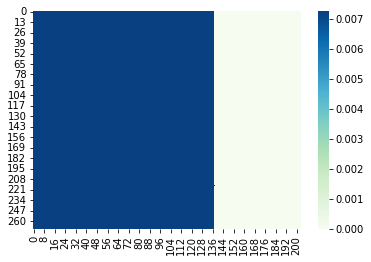

Train Epoch: 1 (0%)	Loss: 0.036140	LR: 0.02


KeyboardInterrupt: ignored

In [163]:
n_epochs = 100
mode = 'train'

teacher_forcing_rate = 1.0

for epoch in range(1, n_epochs + 1):

  print("new epoch starts .................")

  if teacher_forcing_rate > 0.62: 
    if epoch == 10:
      teacher_forcing_rate -= 0.1

    if epoch > 10 and epoch % 5 == 0:
      teacher_forcing_rate -= 0.1

  print(teacher_forcing_rate)
  
  train(model, train_loader, criterion, optimizer, mode, teacher_forcing_rate)
  dev_lev_distance = val(model, val_loader, mode="val")
  scheduler.step(dev_lev_distance)
  torch.save(model.state_dict(), f"model_epoch_{epoch}.pt")
  print(f'Epoch {epoch}/{n_epochs}')
  print('Lev Distance ', dev_lev_distance)

In [145]:
dev_lev_distance = val(model, val_loader, mode="val")

validation


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').


In [146]:
dev_lev_distance

10.124676285608583

In [147]:
train_lev_distance = val(model, train_loader, mode="val")

validation


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').


In [148]:
train_lev_distance

21.77886401065209

In [ ]:
# torch.save(model.state_dict(), f"model_10_epochs.pt")

In [127]:
teacher_forcing_rate = 1
mode = "test"
def test(model, test_loader, mode, teacher_forcing_rate):
  torch.cuda.empty_cache()
  model.eval()

  output_strings = []
  for batch_idx, (x, x_len) in enumerate(test_loader):
      x = x.to(device)
      with torch.no_grad():
        predictions, attentions = model(x, x_len, mode, teacher_forcing_rate)
      pred_text = transform_index_to_letter_test(predictions.argmax(-1).detach().cpu().numpy(), letter2index, index2letter)

      output_strings.extend(pred_text)
      
  return output_strings

In [128]:
output_strings = test(model, test_loader, mode, teacher_forcing_rate)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').


In [129]:
output_strings[0]

'HE BEGAN A CONFUSED COMPLAINT AGAINST THE WHISTERED WHO HAD VANISHED BEHIND THE CURRANT ON THE LEFT'

In [130]:
output = pd.DataFrame()
output['id'] = np.array(range(len(output_strings)))
output['predictions'] = np.array(output_strings) 
output.to_csv("submission.csv", index = False)

In [131]:
!kaggle competitions submit -c 11-785-s22-hw4p2-slack -f submission.csv -m "submission"

100% 291k/291k [00:03<00:00, 97.7kB/s]
Successfully submitted to Attention-Based Speech Recognition (Slack)

In [ ]:
'''
Debugging suggestions from Eason, a TA from previous semesters:

(1) Decrease your batch_size to 2 and print out the value and shape of all intermediate variables to check if they satisfy the expectation
(2) Be super careful about the LR, don't make it too high. Too large LR would lead to divergence and your attention plot will never make sense
(3) Make sure you have correctly handled the situation for time_step = 0 when teacher forcing

(1) is super important and is the most efficient way for debugging. 
'''
'''
Tips for passing A from B (from easy to hard):
** You need to implement all of these yourself without utilizing any library **
(1) Increase model capacity. E.g. increase num_layer of lstm
(2) LR and Teacher Forcing are also very important, you can tune them or their scheduler as well. Do NOT change lr or tf during the warm-up stage!
(3) Weight tying
(4) Locked Dropout - insert between the plstm layers
(5) Pre-training decoder or train an LM to help make predictions
(5) Pre-training decoder to speed up the convergence: 
    disable your encoder and only train the decoder like train a language model
(6) Better weight initialization technique
(7) Batch Norm between plstm. You definitely can try other positions as well
(8) Data Augmentation. Time-masking, frequency masking
(9) Weight smoothing (avg the last few epoch's weight)
(10) You can try CNN + Maxpooling (Avg). Some students replace the entire plstm blocks with it and some just combine them together.
(11) Beam Search
'''